### 1. Install Required Libraries

In [1]:
!pip install datasets transformers biopython torch scikit-learn pandas matplotlib

### 2. Import Libraries

In [56]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification,  Trainer, TrainingArguments
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### 3. Load the data

In [57]:
data = {
    'sequence': [
        "ATGCGTACGTTAGCTAGCTAGCTAG",
        "ATGCGTACGTTAGCTAGCTGCGTAC",
        "ATGCGTACGGTAGCTAGCTAAGTAC",
        "ATGCGTACGGTTAGCTAGCGGTACC",
        "CGTACGTTAGCTAGCGTACGCTGAA",
        "TGCATGCGTACGATGCTAGCTAGTC",
        "GTAGCTGACGTAGCAGTACGTCGAT",
        "CGTACGTAGCTAGCGATACGTAGTA",
        "TGCATGCGTGCATACGGTAGCAGTC",
        "ATGCGTACGTAAGTCTGACGTACGA"
    ],
    'expression': [12.5, 4.2, 0.8, 5.6, 15.2, 6.7, 8.9, 3.4, 14.1, 2.3]  # Expression levels for the respective sequences
}

df = pd.DataFrame(data)

df.head()

,sequence,expression
0,ATGCGTACGTTAGCTAGCTAGCTAG,12.5
1,ATGCGTACGTTAGCTAGCTGCGTAC,4.2
2,ATGCGTACGGTAGCTAGCTAAGTAC,0.8
3,ATGCGTACGGTTAGCTAGCGGTACC,5.6
4,CGTACGTTAGCTAGCGTACGCTGAA,15.2


### 4. Convert the DataFrame to a Hugging Face Dataset

In [58]:
dataset = Dataset.from_pandas(df)

### 5. Tokenize the sequences

In [59]:
# Split into train and eval datasets (80-20 split)
train_dataset = dataset.shuffle(seed=42).select([i for i in range(int(0.8 * len(dataset)))])  # 80% for training
eval_dataset = dataset.shuffle(seed=42).select([i for i in range(int(0.8 * len(dataset)), len(dataset))])  # 20% for eval

# Load a pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['sequence'], padding=True, truncation=True)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

### 6. Ensure correct dtype for labels (float32 for regression task)

In [60]:
train_dataset = train_dataset.map(lambda example: {
    "input_ids": torch.tensor(example["input_ids"], dtype=torch.int64),  # Convert to PyTorch tensor
    "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.int64),  # Convert to PyTorch tensor
    "labels": torch.tensor(example["expression"], dtype=torch.float32)  # Convert expression to float32
})

eval_dataset = eval_dataset.map(lambda example: {
    "input_ids": torch.tensor(example["input_ids"], dtype=torch.int64),  # Convert to PyTorch tensor
    "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.int64),  # Convert to PyTorch tensor
    "labels": torch.tensor(example["expression"], dtype=torch.float32)  # Convert expression to float32
})


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

### 7. Load the pre-trained BERT model for regression

In [61]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 8. Set up training arguments

In [62]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=10,              # Number of training epochs
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Log directory
    report_to="none"                 # Disable wandb logging
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 9. Set up the Trainer

In [63]:
trainer = Trainer(
    model=model,                         # The model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=eval_dataset,           # Evaluation dataset
)

### 10. Start the training process

In [64]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,94.678459
2,No log,93.296341
3,No log,92.197655
4,No log,90.994621
5,No log,89.879318
6,No log,89.002991
7,No log,88.212181
8,No log,87.437294
9,No log,86.818710
10,No log,86.516983


TrainOutput(global_step=10, training_loss=57.657537841796874, metrics={'train_runtime': 58.1883, 'train_samples_per_second': 1.375, 'train_steps_per_second': 0.172, 'total_flos': 616660999200.0, 'train_loss': 57.657537841796874, 'epoch': 10.0})

### 11. Evaluate the model's performance (on the validation set)

In [65]:
predictions = trainer.predict(eval_dataset)

# Get predicted values and calculate metrics
y_true = eval_dataset['expression']
y_pred = predictions.predictions.flatten()

# Calculate RMSE and MAE
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

# Print out the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 9.30145077776601
MAE: 7.866210722923279


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [66]:
# Extra
print(f"Number of samples in dataset: {len(df)}")
print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in evaluation dataset: {len(eval_dataset)}")

Number of samples in dataset: 10
Number of samples in training dataset: 8
Number of samples in evaluation dataset: 2


### 12. Visualize results (True vs Predicted values)

True values: [4.2, 14.1]
Predicted values: [1.2976301 1.2699485]


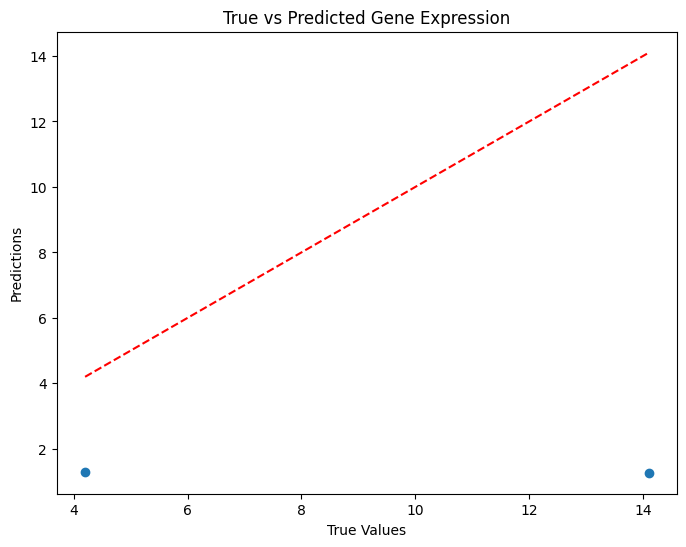

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Check the length and contents of y_true and y_pred
print("True values:", y_true)
print("Predicted values:", y_pred)

# Convert y_true to numpy array if it's not already
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 10: Visualize results (True vs Predicted values)
plt.figure(figsize=(8, 6))

# Ensure that there's more than one point in the plot
if len(y_true) > 1:
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Gene Expression')
    plt.show()
else:
    print("Insufficient data for plotting. Only one value found.")
